# XGBoost - diabetes (Regression)
[ch5-advanced-xgboost-unveiled.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch5-advanced-xgboost-unveiled.ipynb)

In [1]:
!pip install xgboost

You should consider upgrading via the '/Users/ksdyb/.pyenv/versions/3.9.12/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
import xgboost as xgb
xgb.set_config(verbosity=0)

## Define Feature and Target

In [5]:
from sklearn import datasets
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

In [6]:
pd.DataFrame(y).describe()

,target
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


In [7]:
pd.DataFrame(y).value_counts()

target
200.0     6
72.0      6
90.0      5
178.0     5
71.0      5
         ..
162.0     1
161.0     1
31.0      1
156.0     1
346.0     1
Length: 214, dtype: int64

In [8]:
pd.DataFrame(y).head()

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [9]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [10]:
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  442 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB


In [11]:
pd.DataFrame(X).isna().sum().sum()

0

## Regression Model Selection

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score

# kfold = KFold(n_splits=5, shuffle=True, random_state=2)
kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)
    
    rmse = np.sqrt(-scores)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('RMSE:', np.round(rmse, 3))
    print('Avg. RMSE: %0.3f' % (rmse.mean()))

In [13]:
cross_validation(XGBRegressor(booster='gbtree'))

Cross Validation:
Elased time: 0.99s
RMSE: [67.244 65.664 59.644 67.274 59.144]
Avg. RMSE: 63.794


In [14]:
cross_validation(XGBRegressor(booster='gblinear'))

Cross Validation:
Elased time: 0.15s
RMSE: [55.664 53.427 52.867 60.706 53.876]
Avg. RMSE: 55.308


In [15]:
cross_validation(XGBRegressor(booster='dart', one_drop=1))

Cross Validation:
Elased time: 10.86s
RMSE: [67.297 58.571 60.46  69.981 56.161]
Avg. RMSE: 62.494


In [16]:
from sklearn.linear_model import LinearRegression, LogisticRegression

cross_validation(LinearRegression())

Cross Validation:
Elased time: 0.01s
RMSE: [55.656 53.528 52.543 60.33  54.131]
Avg. RMSE: 55.238


In [17]:
from sklearn.linear_model import Lasso

cross_validation(Lasso())

Cross Validation:
Elased time: 0.01s
RMSE: [58.032 59.076 62.663 67.652 63.679]
Avg. RMSE: 62.220


In [18]:
from sklearn.linear_model import Ridge

cross_validation(Ridge())

Cross Validation:
Elased time: 0.01s
RMSE: [56.249 55.534 60.368 62.989 57.813]
Avg. RMSE: 58.591


In [19]:
from sklearn.ensemble import RandomForestRegressor

cross_validation(RandomForestRegressor())

Cross Validation:
Elased time: 0.59s
RMSE: [58.13  52.355 58.458 63.046 56.049]
Avg. RMSE: 57.608


## HPO

### Default

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Utility function to estimate accuracy scores
def model_estimation(model):    
    y_pred = model.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('RMSE: %0.3f' % (reg_rmse))   
    
    return reg_rmse

In [21]:
# basic model
model = XGBRegressor(booster='gbtree', random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

best_rmse = model_estimation(model)
best_model = model

print('\nbest_score: %0.3f' % (best_rmse))

RMSE: 64.183

best_score: 64.183


In [22]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score(=RMSE): {0:.3f}".format(
                    np.sqrt(-results["mean_test_score"][candidate]),
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

## HPO: Randomized Search

In [23]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    xgb = XGBRegressor(booster='gbtree', random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_reg = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='neg_mean_squared_error')
    
    rand_reg.fit(X_train, y_train)    
    
    best_model = rand_reg.best_estimator_    
    
    print("best parameter:", rand_reg.best_params_)
    
    rmse = np.sqrt(-rand_reg.best_score_)
    print("best rmse: {:.3f}".format(rmse))

    return best_model

In [24]:
import time
start = time.time()

randomized_model = randomized_search(
    params={
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8],
        'max_depth':[1, 2, 3, 5, 6, 8],
        'gamma':[0, 0.01, 0.1, 0.5, 0.7, 1, 2],
        'min_child_weight':[5, 10, 15, 20, 30],
        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'colsample_bytree':[0.2, 0.5, 0.7, 0.8, 0.9, 1],  
        }, 
    runs=20)

print('\nElapsed time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 20, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}
best rmse: 55.325

Elapsed time: 4.78s


In [25]:
rmse = model_estimation(randomized_model)
print('\nscore: %0.3f' % (rmse))  

if(rmse < best_rmse):
    best_rmse = rmse
    best_model = model

    print('best_score: %0.3f' % (best_rmse))  

RMSE: 58.689

score: 58.689
best_score: 58.689


## HPO: Bayesian Optimization 

In [26]:
from bayes_opt import BayesianOptimization

def xgbc_cv(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, ):
    xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                        n_estimators=int(n_estimators),
                        learning_rate=learning_rate,
                        max_depth=int(max_depth),
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

    xgb.fit(X_train, y_train)    

    y_pred = xgb.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('RMSE: %0.3f' % (reg_rmse))   

    return -reg_rmse

hyperparameter_space = {
    'n_estimators': (50, 800),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 8),
    'gamma' : (0.01, 1),
    'min_child_weight': (1, 20),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.1, 1)
}

optimizer = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=2, verbose=0)

#gp_params = {"alpha": 1e-10}
#optimizer.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)    

#optimizer.maximize(init_points=2, n_iter=10)
optimizer.maximize(init_points=3, n_iter=5, acq='ei')

optimizer.max

RMSE: 80.229
RMSE: 63.177
RMSE: 73.829
RMSE: 61.917
RMSE: 73.425
RMSE: 58.615
RMSE: 62.388
RMSE: 60.270


{'target': -58.61492962200877,
 'params': {'colsample_bytree': 0.11682121232665195,
  'gamma': 0.5363937166546405,
  'learning_rate': 0.20820799345993884,
  'max_depth': 1.701452973304049,
  'min_child_weight': 8.675113792944344,
  'n_estimators': 151.92975674856012,
  'subsample': 0.500269214951824}}

In [27]:
best_params = optimizer.max['params']

In [28]:
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                        n_estimators=int(best_params['n_estimators']), 
                        learning_rate=best_params['learning_rate'], 
                        max_depth=int(best_params['max_depth']), 
                        gamma=best_params['gamma'], 
                        min_child_weight=int(best_params['min_child_weight']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

y_pred = model.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)

print('Elapsed time: %0.2fs' % (time.time()-start))        
print('RMSE: %0.3f' % (reg_rmse))  

if(reg_rmse < best_rmse): 
    best_rmse = reg_rmse
    best_model = model
    
    print('\nbest_score: %0.3f' % (best_rmse))                     

Elapsed time: 7.45s
RMSE: 58.678

best_score: 58.678


## Evaluation

In [29]:
model_estimation(best_model)    

RMSE: 58.678


58.6780129589296

In [30]:
print(best_model.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.11682121232665195, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.5363937166546405, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.20820799345993884, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 1, 'max_leaves': 0, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 151, 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.500269214951824, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'use_label_encoder': False}


## Feature Importances

Feature Importances:
[0.0329456  0.02927405 0.13527647 0.2695053  0.05685844 0.0592644
 0.10351827 0.0717003  0.16530474 0.07635243]
You should consider upgrading via the '/Users/ksdyb/.pyenv/versions/3.9.12/bin/python3.9 -m pip install --upgrade pip' command.


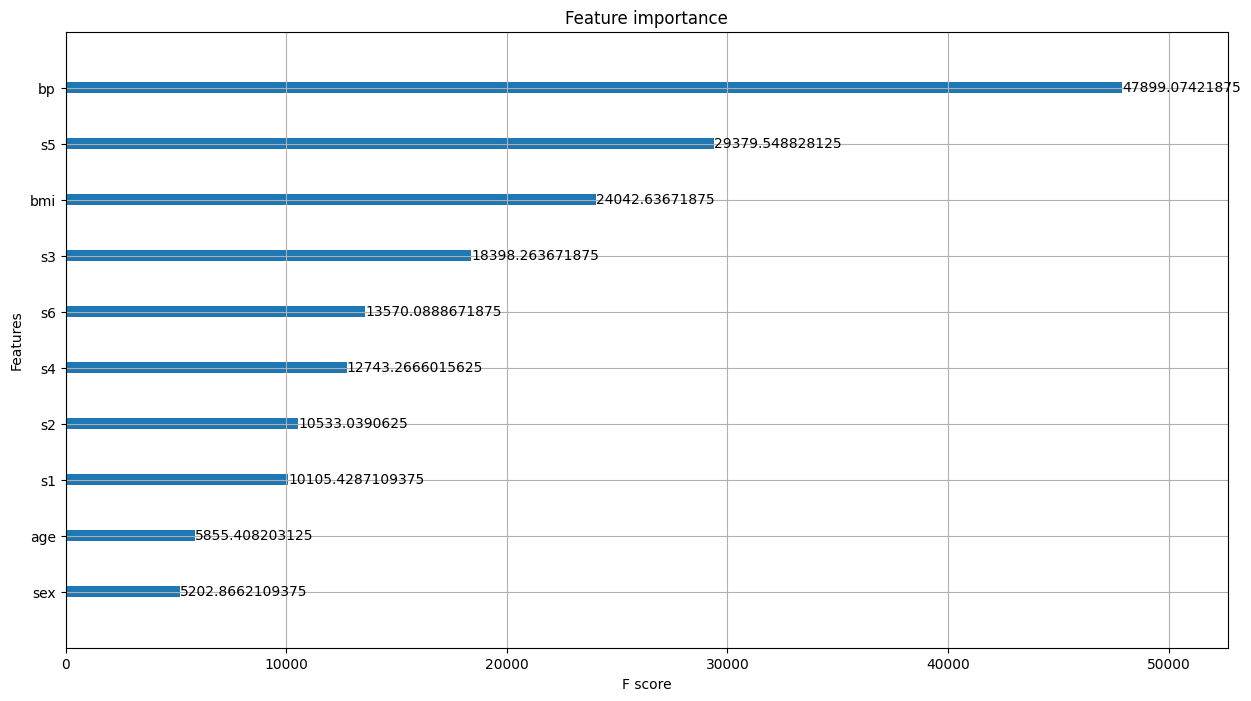

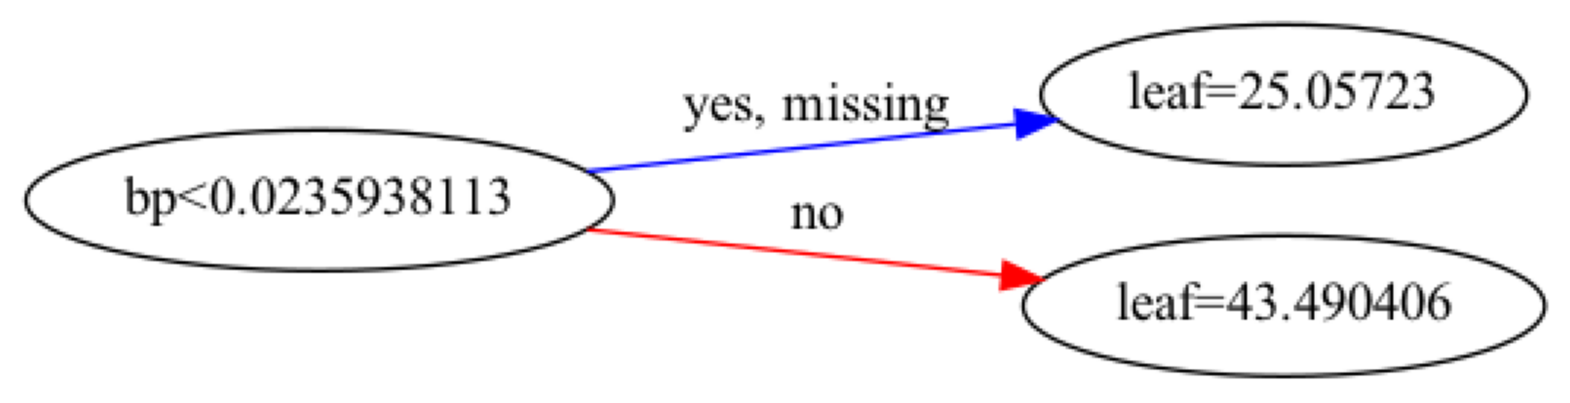

In [31]:
print('Feature Importances:')
print(best_model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
best_model.get_booster().feature_names = feature_data.feature_names
best_model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(best_model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

### HPO - GridSearchCV

In [32]:
import time
from sklearn.model_selection import GridSearchCV

def grid_search(params, reg=XGBRegressor(booster='gblinear')):
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    start = time.time()
    
    grid_reg.fit(X, y)

    best_params = grid_reg.best_params_
    print("best parameter:", best_params)
    
    best_score = np.sqrt(-grid_reg.best_score_)
    print("best accuracy:", best_score)    
    print('Elased time: %0.2fs' % (time.time()-start))

    return grid_reg.best_estimator_

In [33]:
grid_search(params={'reg_alpha':[0.001, 0.01, 0.1, 0.5, 1, 5]})

best parameter: {'reg_alpha': 0.01}
best accuracy: 55.34239497982048
Elased time: 0.83s


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0.01, reg_lambda=0, ...)

In [34]:
grid_search(params={'reg_lambda':[0.001, 0.01, 0.1, 0.5, 1, 5]})

best parameter: {'reg_lambda': 0.001}
best accuracy: 56.00849937109271
Elased time: 0.81s


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0.001, ...)

In [35]:
grid_search(params={'feature_selector':['shuffle']})

best parameter: {'feature_selector': 'shuffle'}
best accuracy: 55.32115672716604
Elased time: 0.17s


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_selector='shuffle', gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, ...)

In [36]:
grid_search(params={'feature_selector':['random', 'greedy', 'thrifty'], 
                    'updater':['coord_descent'] })

best parameter: {'feature_selector': 'greedy', 'updater': 'coord_descent'}
best accuracy: 55.29884515795315
Elased time: 1.69s


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_selector='greedy', gamma=None, gpu_id=-1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, ...)

In [37]:
grid_search(params={'feature_selector':['greedy', 'thrifty'], 
                    'updater':['coord_descent'], 'top_k':[3, 5, 7, 9]})

best parameter: {'feature_selector': 'greedy', 'top_k': 9, 'updater': 'coord_descent'}
best accuracy: 55.29884515795315
Elased time: 3.34s


XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_selector='greedy', gamma=None, gpu_id=-1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, ...)

In [38]:
param_grid = [{'updater':['shotgun'],
               'feature_selector':['cyclic', 'shuffle']},
              {'updater':['coord_descent'],
               'feature_selector':['random', 'greedy', 'thrifty']}]
model = grid_search(params=param_grid)

best parameter: {'feature_selector': 'greedy', 'updater': 'coord_descent'}
best accuracy: 55.29884515795315
Elased time: 1.95s


In [42]:
model_estimation(best_model)    

RMSE: 58.678


58.6780129589296

In [39]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gblinear',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': -1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': 1,
 'verbosity': None,
 'feature_selector': 'greedy',
 'updater': 'coord_descent'}

In [40]:
X = np.arange(1,100)
np.random.seed(2) 
y = []
for i in X:
    y.append(i*np.random.uniform(-0.2, 0.2))
y = np.array(y)
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

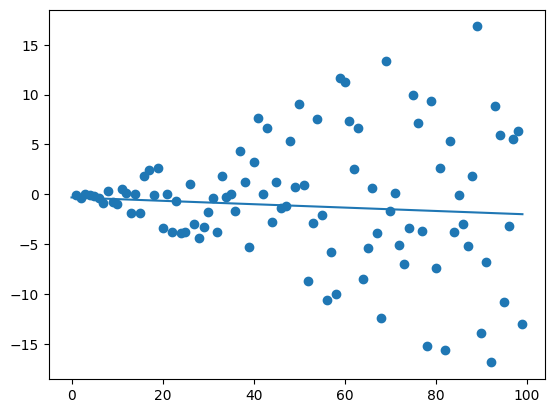

In [41]:
import matplotlib.pyplot as plt

xgbr = XGBRegressor(booster='gblinear')
xgbr.fit(X, y)

plt.scatter(X, y)
plt.plot((0, 99), (xgbr.intercept_, xgbr.coef_*99+xgbr.intercept_))
plt.show()